 Importing necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import textblob, string
import xgboost as xgb
# keras
from keras import layers, models, optimizers
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import text, sequence
from lightgbm import LGBMClassifier
# sklearn
from sklearn import decomposition, ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
# algos
from textblob import TextBlob
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from warnings import filterwarnings

filterwarnings('ignore')
import matplotlib.pyplot as plt

# stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
seed = 7
np.random.seed(seed)
%matplotlib inline
print("Successfully imported Libraries")

Successfully imported Libraries


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Reading Datasets

In [ ]:
pc10000 = "PC5_training_data_10000.txt"
pc130000 = "PC4_training_data_130000.txt"
pc40000 = "PC5_training_data_40000.txt"
pctest = "PC5_test_data_without_stars.txt"

col =['votes', 'stars', 'text']

df10 = pd.read_csv(pc10000, sep ="|",names=col)
df = pd.read_csv(pc40000, sep ="|",names=col)

df130 = pd.read_csv(pc130000, sep ="|",names=col)

df_test = pd.read_csv(pctest, sep ="|",names=['votes', 'text'])

In [ ]:
train = df#copying train dataset
a = train.groupby("stars").count()
print(a, end  ="\n\n")
test = df_test #copying test dataset
train.head()
test.head()

       votes   text
stars              
1       3051   3051
2       3581   3581
3       6121   6121
4      13988  13988
5      13259  13259



,votes,text
0,10,This place and the people there are AWESOMEMy ...
1,0,Have been back now three times since the origi...
2,0,"I like the food here, everything is fresh and ..."
3,0,Spa is tiny. Terrible. You can hear someone ur...
4,2,"The minute you walk in, you feel the intimacy,..."


Stopwords and Cleaning as Required on data

In [ ]:
import nltk
from nltk.corpus import stopwords
# setting stopwards for language English
sw = (stopwords.words('english'))
# print(sw)
def transformations(dataframe):
    # upper to lower case
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #punctuations
    dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
    #numbers
    dataframe['text'] = dataframe['text'].str.replace('\d','')
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    #rare characters deleting
    sil = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-1000:]
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))
    #lemmatizer
    from textblob import Word
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
    return dataframe

train = transformations(train)
train.head()

,votes,stars,text
0,1,5,bought coupon kgb deal finally went last night...
1,2,2,first live die sushi love try different sushi ...
2,1,1,cannot even begin say disgusted baby r u phx r...
3,1,4,great food smoked duck breast walnut sandwich ...
4,1,3,visited ldms bell cow location central totally...


Value Counts of sentiment Labels

1    0.076275
2    0.089525
3    0.153025
4    0.349700
5    0.331475
Name: stars, dtype: float64


Text(0, 0.5, 'Frequency')

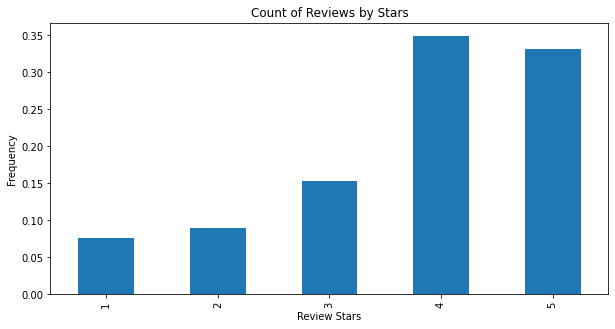

In [ ]:
g = train['stars'].value_counts(normalize = True).sort_index()
print(g)
graph = g.plot(kind='bar', title='Count of Reviews by Stars', figsize=(10,5))
graph.set_xlabel('Review Stars')
graph.set_ylabel('Frequency')

,votes,text length
votes,1.000000,0.658232
text length,0.658232,1.000000


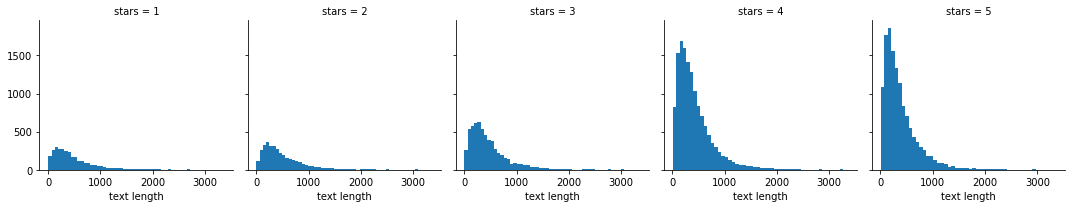

In [ ]:
train['text length'] = train['text'].apply(len)
train.head()
g = sns.FacetGrid(train, col='stars')
g.map(plt.hist, 'text length', bins=50)

stars = train.groupby('stars').mean()
stars.corr()

0    bought coupon kgb deal finally went last night...
1    first live die sushi love try different sushi ...
2    cannot even begin say disgusted baby r u phx r...
3    great food smoked duck breast walnut sandwich ...
4    visited ldms bell cow location central totally...
Name: text, dtype: object
0    1
1    0
2    0
3    0
4    0
Name: stars, dtype: int64
0    This place and the people there are AWESOMEMy ...
1    Have been back now three times since the origi...
2    I like the food here, everything is fresh and ...
3    Spa is tiny. Terrible. You can hear someone ur...
4    The minute you walk in, you feel the intimacy,...
Name: text, dtype: object


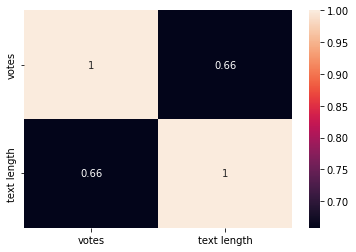

In [ ]:
ab = sns.heatmap(data=stars.corr(), annot=True)
# print(ab)
# train_class = train[(train['stars'] == 1) | (train['stars'] == 3) | (train['stars'] == 5)]
train_class = train

train_class.head()
train_class.shape 
# 16.3k vs 40k

X = train_class['text']
print(X.head(), end="\n")
# y = train_class['stars']
train_class['stars'] = np.where(train_class['stars'] > 4, 1, 0)
y = train_class['stars']
print(y.head())

Z = test['text']
print(Z.head(), end="\n")


Using Count Vectorizer to categorize text

In [ ]:
def text_process(text):
  return [word for word in text.split()]
  
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)
print("Vectorizer vocabulary size: " , len(bow_transformer.vocabulary_))

X = bow_transformer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))


bow_transformer = CountVectorizer(analyzer=text_process).fit(Z)
print("Vectorizer vocabulary size: " , len(bow_transformer.vocabulary_))

Z = bow_transformer.transform(Z)

Vectorizer vocabulary size:  95723
Shape of Sparse Matrix:  (40000, 95723)
Amount of Non-Zero occurrences:  2217570
Density: 0.05791633149817703
Vectorizer vocabulary size:  180726


_______________________







Split Train, Test Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# # splitting 25% of data as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print("X_test\n\n",X_test)
# print("len: ", len(X_test))
print(X_test.shape[0])
ans = {}  # dictionary to hold accuracy values

# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X, y)
print("Confusion Matrix for Multinomial Naive Bayes:")
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
val = round(accuracy_score(y_test,preds)*100,2)
print("Score:",val)
print(classification_report(y_test, preds))

ans["Multinomial Naive Bayes"] = val



X_test

   (0, 2182)	1
  (0, 12149)	1
  (0, 13329)	1
  (0, 25535)	1
  (0, 30158)	1
  (0, 30166)	1
  (0, 36511)	1
  (0, 37464)	1
  (0, 39164)	1
  (0, 41424)	1
  (0, 44298)	1
  (0, 45936)	1
  (0, 46621)	1
  (0, 47426)	1
  (0, 47902)	1
  (0, 48711)	1
  (0, 50686)	1
  (0, 51940)	1
  (0, 55030)	1
  (0, 58296)	1
  (0, 65103)	1
  (0, 65513)	1
  (0, 67413)	2
  (0, 73498)	1
  (0, 86647)	1
  :	:
  (9999, 48359)	1
  (9999, 48503)	1
  (9999, 53556)	1
  (9999, 53815)	1
  (9999, 55045)	1
  (9999, 57724)	1
  (9999, 58487)	1
  (9999, 59828)	1
  (9999, 61310)	1
  (9999, 62898)	2
  (9999, 69892)	1
  (9999, 71238)	1
  (9999, 73327)	1
  (9999, 73379)	1
  (9999, 78853)	1
  (9999, 79002)	1
  (9999, 79458)	1
  (9999, 79940)	2
  (9999, 80603)	3
  (9999, 80721)	1
  (9999, 82604)	1
  (9999, 84247)	1
  (9999, 87477)	1
  (9999, 89172)	1
  (9999, 91173)	1
10000
Confusion Matrix for Multinomial Naive Bayes:
[[6714    0]
 [3286    0]]
Score: 67.14
              precision    recall  f1-score   support

           0  

In [ ]:

# #Gradient Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# #Boosting
# gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
# gbi.fit(X_train,y_train)
# predgbi = gbi.predict(X_test)
# print("Confusion Matrix for Gradient Boosting Classifier:")
# print(confusion_matrix(y_test,predgbi))
# val = round(accuracy_score(y_test,predgbi)*100,2)
# print("Score:",val)
# print("Classification Report:\n",classification_report(y_test,predgbi))

# ans["Gradient Boosting"] = val

{'Multinomial Naive Bayes': 76.24}


In [ ]:
# # Random Forest
# from sklearn.ensemble import RandomForestClassifier
# rmfr = RandomForestClassifier()
# rmfr.fit(X_train,y_train)
# predrmfr = rmfr.predict(X_test)
# print("Confusion Matrix for Random Forest Classifier:")
# print(confusion_matrix(y_test,predrmfr))
# val = round(accuracy_score(y_test,predrmfr)*100,2)
# print("Score:",val)
# print("Classification Report:\n",classification_report(y_test,predgbi))
# ans["Random Forest Classifier"] = val

In [ ]:
# # Decision Tree
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier()
# dt.fit(X_train,y_train)
# preddt = dt.predict(X_test)
# print("Confusion Matrix for Decision Tree:")
# print(confusion_matrix(y_test,preddt))
# val = round(accuracy_score(y_test,preddt)*100,2)
# print("Score:",val)
# print("Classification Report:\n",classification_report(y_test,preddt))
# ans["Decision Tree"] = val

In [ ]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train,y_train)
predsvm = svm.predict(Z)
print("LEN: ",len(predsvm))
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
val = round(accuracy_score(y_test,predsvm)*100,2)
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:\n",classification_report(y_test,predsvm))
ans["Vector Machine"] = val

In [ ]:
from sklearn import *
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=100, random_state=11)
# from sklearn.svm import SVC
# svm = SVC(random_state=101)
# svm.fit(X_train,y_train)
predsvm = svm.predict(Z)
print("LEN: ",len(predsvm))
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
val = round(accuracy_score(y_test,predsvm)*100,2)
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:\n",classification_report(y_test,predsvm))
ans["Vector Machine"] = val

AttributeError: ignored

In [ ]:
pd.DataFrame(predsvm).to_csv('sample.csv') 

In [ ]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=600)
knn.fit(X_train,y_train)
predknn = knn.predict(X_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
val = round(accuracy_score(y_test,predknn)*100,2)
print("Score: ",val)
print("Classification Report:")
print(classification_report(y_test,predknn))
ans["KNN"] = val

KeyboardInterrupt: ignored

In [ ]:
# # XGBoost Classifier
# import xgboost
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train,y_train)
# predxgb = xgb.predict(X_test)
# print("Confusion Matrix for XGBoost Classifier:")
# print(confusion_matrix(y_test,predxgb))
# val= round(accuracy_score(y_test,predxgb)*100,2)
# print("Score: ",val)
# print("Classification Report:")
# print(classification_report(y_test,predxgb))
# ans["XGBoosting"] = val

In [ ]:
# # MULTILAYER PERCEPTRON CLASSIFIER
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier()
# mlp.fit(X_train,y_train)
# predmlp = mlp.predict(X_test)
# print("Confusion Matrix for Multilayer Perceptron Classifier:")
# print(confusion_matrix(y_test,predmlp))
# val = round(accuracy_score(y_test,predmlp)*100,2)
# print("Score:",val)
# print("Classification Report:")
# print(classification_report(y_test,predmlp))
# ans["MLP CLassifier"] = val

In [ ]:
print(ans)

{'Multinomial Naive Bayes': 0.0, 'KNN': 25.0}


In [ ]:
X_t = test['text']
bow_transformer = CountVectorizer(analyzer=text_process).fit(X_t)
print("Vectorizer vocabulary size: " , len(bow_transformer.vocabulary_))
X_t = bow_transformer.transform(X_t)
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.25, random_state=11)

from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train,y_train)
arr = svm.predict(Z)

pd.DataFrame(arr).to_csv('sample.csv')    
#print(svm)

Vectorizer vocabulary size:  180726


ValueError: ignored